# Chapter 4 -- Nonlinear Pule Propagation: Self-Phase Modulation, Soliton Formation, Supercontinuum Generation, and Ultrafast Nonlinear Switching

In this recitation we will discuss

 1. Self-phase modulation
   - Soliton formation and evolution
   - Supercontinuum generation
     - Examples in current literature
     - Accounting for higher-order dispersion
     - Spectral properties of importance in real-world situations
 2. Nonlinear nanophotonics example: phase-modulation and THG
   - EM field simulations in a sub-wavelength structure with $\chi^{(3)}$
   - Link back to the Fabry-Perot cavity
   - Recent progress in the literature

## Packages, Functions and Variables -- Run First!

The following code-block contains the packages, functions and variables needed for the code found later in this notebook.  It must be run first.  Note that if you are running this on your personal computer, you should ensure that all packages needed are installed first (for example the [numpy](https://numpy.org/), [scipy](https://scipy.org/), and [matplotlib](https://matplotlib.org/) packages must be installed on your computer along with others).  You can find a launcher link at the top to conveniently run this notebook in Google Colab.  

The code below is hidden by default, but you are encouraged to expand it and study it.  The functions and constants will update as needed during the progression of the course, so you should note what new functions have been and added and study how they work. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import h5py
from scipy import signal


#--Physical Constants--
hbar = 1.054e-34 #normalized Planck constant [J*s]
evcon = 1.602e-19 #conversion factor, [J/eV]
eta = 119.91699832*np.pi #impedance of freespace [ohms]
me = 9.10938188e-31 #mass of electron [kg]
c = 2.99792458e8 #speed of light [m/s]
e = 1.602e-19 #electron charge [C]

#--Gaussian Pulse Function --
def gaussian_pulse(t, fwhm, wc, phi_ce):
    """
    [E, A] = gaussian_pulse(t, fwhm, wc, phi_ce)

    Function for generating a Gaussian pulse form with given intensity FWHM.
    Outputs electric field profile and intensity envelope, both normalized to
    peak of 1.  Units need to be self-consistent between t, fwhm, and wc.

    Inputs:
    -----------
      t --> time 
      fwhm --> full width at half max of the intensity envelope
      wc --> central frequency (rad/unit time)
      phi_ce --> carrier envelope phase offset (rad)

    Outputs:
    -------------
      pulse['E'] --> Electric field profile (peak of 1)
      pulse['A'] --> Intensity envelope (peak of 1)
    
    """


    #Now determine constant for gaussian envelope from fwhm:
    tau = fwhm/(2*np.sqrt(np.log(2)));

    #Finally, define the pulse:
    E_envelope = np.exp(-t**2/(2*tau**2));
    
    pulse = {}

    pulse['E'] = E_envelope*np.cos(wc*t + phi_ce);

    pulse['A'] = E_envelope**2;
    
    return pulse

#Calculate index based on Sellmeier coefficients
# -- Assumes wavelength in microns
def n_sell(y, B, C):
    """
    Calculate index based on Sellmeier coefficients.
    
    Assumes wavelength y in microns.
    
    B and C should be vectors with equal number of coefficients.
    
    Based on forumlation here: https://en.wikipedia.org/wiki/Sellmeier_equation
    """
    
    n2 = np.ones(y.size)
    
    #We are only concerned with wavelengths > 0!
    y_valid = np.where(y > 0)
    
    for m in range(0, len(B)):
        
        n2[y_valid[0]] = n2[y_valid[0]] + B[m]*y[y_valid[0]]**2/(y[y_valid[0]]**2 - C[m])
        
    n = np.sqrt(np.abs(n2))
    
    return n


def split_step(A0, z, f, dt, beta2, beta3, gamma):
    """
    This function carries out the split step procedure 
    to calculate a pulse spectra propagating through the NLSE. The
    split-step implementation here is not optimized in any way. (I'd say
    that it's relatively inefficient.) This function does not use a
    normalized NLSE. (4-21-20).
    
    INPUTS: 
        A0      sqrt(W):    input pulse
        z       mm:         spatial grid to propagate over (uniformly sampled)
        f       PHz:        frequency span for FFTs (defined by t)
        dt      fs:         temporal spacing 
        beta2   fs^2/mm:    GVD
        beta3   fs^3/mm:    TOD
        gamma   1/(W*mm):   nonlinear coeff.
 
    OUTPUTS:
        A   time signal out
        A_f frequency signal out
    """

    Nz = z.size
    
    #z should be uniformly sampled
    dz = z[1]-z[0]

    # initialize 
    A = np.zeros( (Nz, A0.size)) + 0j
    A_f = np.zeros( (Nz, A0.size) ) + 0j
    A[0, :] = A0
    A_f[0, :] = dt*np.fft.fft(A0);

    #calculate all the traces and spectra
    for co in range(1,Nz):
        #spectrum calculation
        Atemp_f = dt * np.exp(-1j/4*beta2*(2*np.pi*f)**2*dz + 1j/12*beta3*(2*np.pi*f)**3*dz)*\
        np.fft.fft( np.exp(-1j*gamma*np.abs(A[co-1, :])**2*dz)*\
        np.fft.ifft( np.exp(-1j/4*beta2*(2*np.pi*f)**2*dz + 1j/12*beta3*(2*np.pi*f)**3*dz)*\
        np.fft.fft( A[co-1, :] ) ) );

        #assignments
        A_f[co, :] = Atemp_f;
        A[co, :] = 1/dt*np.fft.ifft(Atemp_f);
    
    
    return A, A_f

## Self-Phase Modulation

In this section we study important characteristics of self-phase modulation.  We go a bit beyond the lectures to discuss more details about soliton formation, and the impact of higher-order dispersion on supercontinuum generation in more realistic systems.

Note that a new function has been added in teh headers section: `split_step(...)`.  See the function definition for reference.  This will be used throughout the following sections to simulation the effects of self-phase modulation on the propagating pulse.  

### Soliton Formation

We study how solitons form even when the initial pulse is not itself a soliton.  We do this first for a simple Gaussian and then for a top-hat-like pulse.  

#### Starting from an initial Gaussian pulse

We need to start by defining our pulse and its envelope. We can use the pre-defined function in the headers block above for that.

In the interactive script below, start by using the defaults and then come back to play with different pulse shapes.  

In [11]:
# -- Pulse Settings -- 
yc = 1.55 # central wavelength in micrometers
phi_ce = 0
fwhm = 50 #this one is in femtoseconds
N = 10000

#We now define the plotting within a function.
#We do this as we are going to use interactive widgets to let us dynamically
#change parameters and replot.  This can be very useful for visualization
#and study.  


def update(fwhm, yc, phi_ce):

    # -- Plotting -- 
    fig = plt.figure()
    fig.set_size_inches(10, 7)
    
    # -- Calculations  -- 
    t_ax = np.linspace(-fwhm*50, fwhm*50, N) #time in fs
    
    wc = 2*np.pi*c*1e-15/(yc*1e-6) # angular frequency in rad/fs
    
    pulse = gaussian_pulse(t_ax, fwhm, wc, phi_ce*np.pi) #pulse information
    A = np.sqrt(pulse['A']) #code provides intensity envelope, we need to convert to field envelope...
    E = pulse['E'] #Fields for reference



    plt.plot(t_ax, pulse['E'], label='E-Field')
    plt.plot(t_ax, np.sqrt(pulse['A']), label='Envelope')

    plt.xlim(-4*fwhm, 4*fwhm)
    plt.legend()
    plt.xlabel('Time (fs)')
    plt.ylabel('Field/Envelope (Normalized)')
    

    return wc, fwhm, t_ax, A, E

pulse_set = ipywidgets.interactive(update, 
                    fwhm=ipywidgets.FloatText(value=fwhm, description='FWHM (fs)'),
                    yc=ipywidgets.FloatText(value=yc, description = '$\lambda_c$ ($\mu$m)'),
                    phi_ce=ipywidgets.FloatText(value=phi_ce, description = '$\phi_{\mathrm{ce}}$ ($\pi$ rad)'))


display(pulse_set)

interactive(children=(FloatText(value=50.0, description='FWHM (fs)'), FloatText(value=1.55, description='$\\la…

Now use the `split_step` function to propagate this pulse along a nonlinear medium.

In [12]:
#Retrieve values after setting pulse above
wc, fwhm, t_ax, A, E = pulse_set.result

#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(E.size, dt)

z = np.linspace(0, 100.0, 1000)
beta2 = -40.0 #negative GDD for soliton formation
beta3 = 0.0 #TOD -- set to 0.0 for now
gamma = 0.07 #Should be balanced with gamma
A_out, A_out_f = split_step(A, z, w/2/np.pi, dt, beta2, beta3, gamma)

Now plot the output at various points along the propagation length.

Text(0, 0.5, 'Intensity')

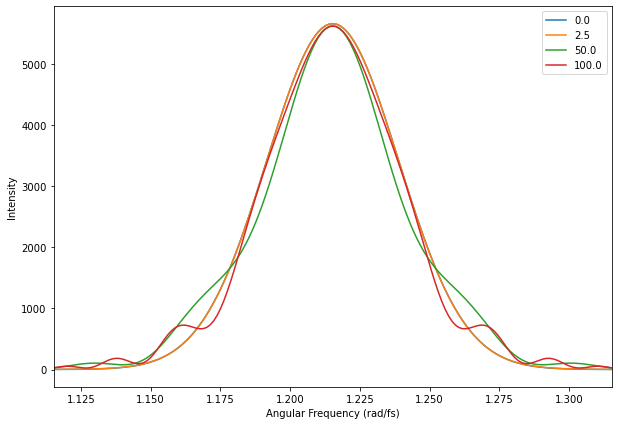

In [13]:
#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[0, :].squeeze())**2), label=str(0/1000*100))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[25, :].squeeze())**2), label=str(25/1000*100))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[500, :].squeeze())**2), label=str(500/1000*100))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[-1, :].squeeze())**2), label=str(1000/1000*100))
plt.xlim(wc - 0.1, wc + 0.1)

plt.legend()
plt.xlabel('Angular Frequency (rad/fs)')
plt.ylabel('Intensity')

Note that the basic spectrum quickly changes and starts to converge to a similar shape after that.  There are higher frequency ripples that continue to get tighter and go away as the pulse propagates.  In time, however, the pulses are quite smooth and quickly take on the `sech`-shaped formation that is the hallmark of a soliton.  

The following script plots the time-domain behavior at the points chosen above.

Text(0, 0.5, 'Intensity')

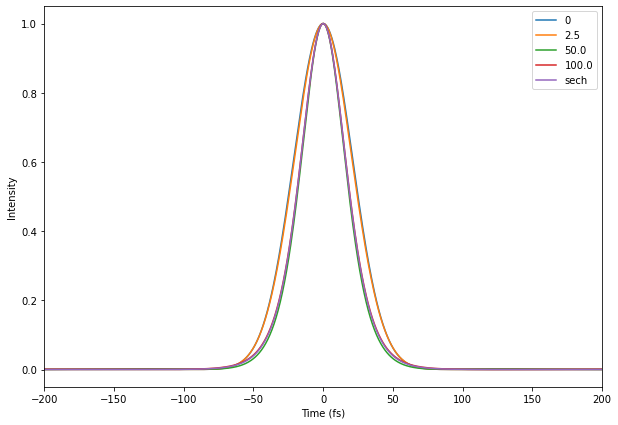

In [14]:
#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

#Calculate tau given final parameters:
tau = np.sqrt(np.abs(beta2)/np.max(np.abs(A_out[-1,:]))**2/gamma)

plt.plot(t_ax, np.abs(A_out[0, :].squeeze())**2, label='0')
plt.plot(t_ax, np.abs(A_out[25, :].squeeze()/np.max(np.abs(A_out[25, :].squeeze())))**2, label=str(25/1000*100))
# # plt.plot(t_ax, np.abs(A_out[50, :].squeeze()/np.max(np.abs(A_out[50, :].squeeze())))**2)
# # plt.plot(t_ax, np.abs(A_out[250, :].squeeze()/np.max(np.abs(A_out[250, :].squeeze())))**2)
plt.plot(t_ax, np.abs(A_out[500, :].squeeze()/np.max(np.abs(A_out[500, :].squeeze())))**2, label=str(500/1000*100))
plt.plot(t_ax, np.abs(A_out[-1, :].squeeze()/np.max(np.abs(A_out[-1, :].squeeze())))**2, label=str(1000/1000*100))
plt.plot(t_ax, (1/np.cosh(t_ax/tau))**2, label='sech')


#plt.xlim(wc - 0.1, wc + 0.1)
plt.xlim(-200, 200)
plt.legend()

plt.xlabel('Time (fs)')
plt.ylabel('Intensity')

Text(0, 0.5, 'Distance (mm)')

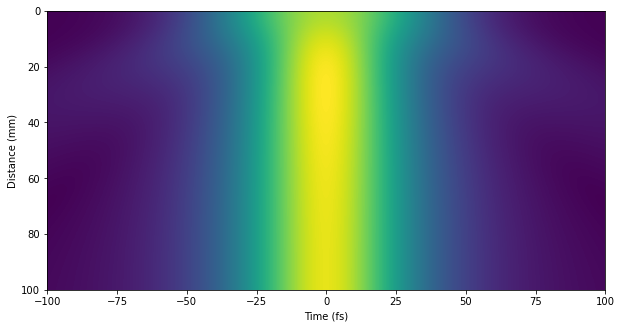

In [15]:
fig = plt.figure()
fig.set_size_inches(10, 7)

extent = [t_ax[0], t_ax[-1], z[-1], z[0]]
plt.imshow(np.abs(A_out), extent=extent)
plt.xlim(-100, 100)
plt.xlabel('Time (fs)')
plt.ylabel('Distance (mm)')

#### Starting from a "flat-top" pulse

We can use a tukey window to create a flat-topped pulse as our input, keeping all other settings the same.

This starts to get tricky as with very fast edges you have higher frequency components which can create some numerical issues.  We avoid this by smoothing out thedges using a tukey window.  

Interestingly, despite the very different initial pulse shape, the frequency spectrum rapidly changes to one similar to the Gaussian input and the time-domain pulse takes on the same `sech` shape as with the Gaussian case (superimposed below again for comparison). 

This is a main reason soliton propagation is so attractive.  Despite widely varying input conditions, the system naturally "cleans" the input resulting in a well-defined and repeatable pulse shape each time.

Many oscillators leverage this principal to start from a "seed" transient which eventually washes out to a repeatable soliton solution.  

In [16]:
#Retrieve values after setting pulse above
wc, fwhm, t_ax, A, E = pulse_set.result

A_sq = np.zeros(t_ax.shape)
T = 50
A_sq[np.where(np.abs(t_ax) < T)[0]] = signal.tukey(np.where(np.abs(t_ax) < T)[0].size, alpha=0.75)

#Take the FT of the envelope
A_sq_f = np.fft.fft(A_sq)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(E.size, dt)

z = np.linspace(0, 100.0, 1000)
beta2 = -40.0 #negative GDD for soliton formation
beta3 = 0.0 #TOD -- set to 0.0 for now
gamma = 0.1 #Should be balanced with gamma
A_sq_out, A_sq_out_f = split_step(A_sq, z, w/2/np.pi, dt, beta2, beta3, gamma)




Text(0, 0.5, 'Intensity (arb. units)')

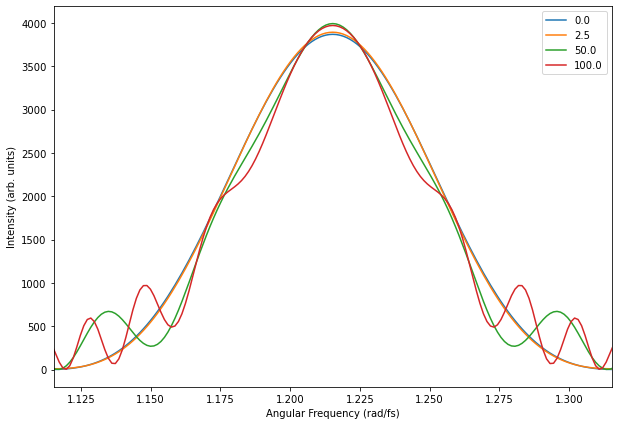

In [17]:
#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_sq_out_f[0, :].squeeze())**2), label=str(0/1000*100))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_sq_out_f[25, :].squeeze())**2), label=str(25/1000*100))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_sq_out_f[500, :].squeeze())**2), label=str(500/1000*100))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_sq_out_f[-1, :].squeeze())**2), label=str(1000/1000*100))
plt.xlim(wc - 0.1, wc + 0.1)

plt.legend()
plt.xlabel('Angular Frequency (rad/fs)')
plt.ylabel('Intensity (arb. units)')

Again, we then take a look at the pulse at select points in the time-domain.

Text(0, 0.5, 'Intensity (arb. units)')

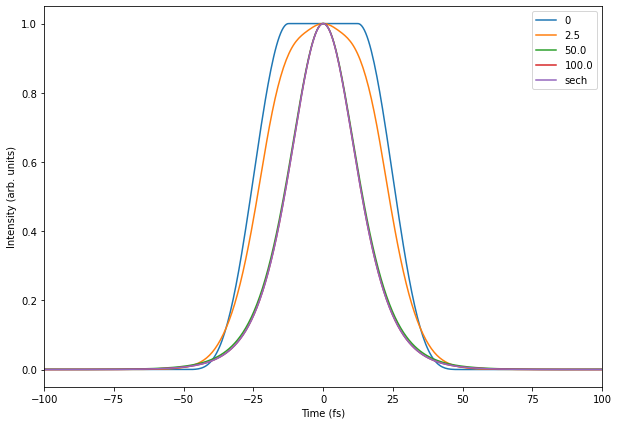

In [18]:
#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

#Calculate tau given final parameters:
tau = np.sqrt(np.abs(beta2)/np.max(np.abs(A_sq_out[-1,:]))**2/gamma)

plt.plot(t_ax, np.abs(A_sq_out[0, :].squeeze())**2, label='0')
plt.plot(t_ax, np.abs(A_sq_out[25, :].squeeze()/np.max(np.abs(A_sq_out[25, :].squeeze())))**2, label=str(25/1000*100))
plt.plot(t_ax, np.abs(A_sq_out[500, :].squeeze()/np.max(np.abs(A_sq_out[500, :].squeeze())))**2, label=str(500/1000*100))
plt.plot(t_ax, np.abs(A_sq_out[-1, :].squeeze()/np.max(np.abs(A_sq_out[-1, :].squeeze())))**2, label=str(1000/1000*100))
plt.plot(t_ax, (1/np.cosh(t_ax/tau))**2, label='sech')


#plt.xlim(wc - 0.1, wc + 0.1)
plt.xlim(-100, 100)
plt.legend()

plt.xlabel('Time (fs)')
plt.ylabel('Intensity (arb. units)')

Text(0, 0.5, 'Distance (mm)')

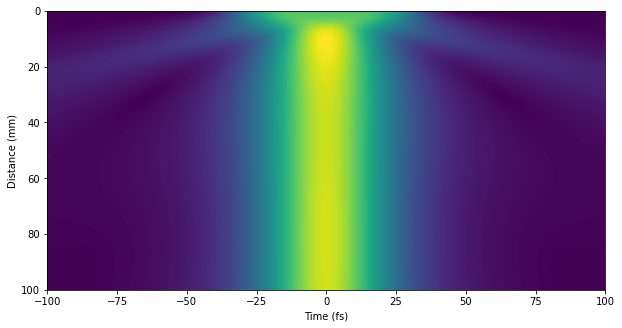

In [19]:
fig = plt.figure()
fig.set_size_inches(10, 7)

extent = [t_ax[0], t_ax[-1], z[-1], z[0]]
plt.imshow(np.abs(A_sq_out), extent=extent)
plt.xlim(-100, 100)
plt.xlabel('Time (fs)')
plt.ylabel('Distance (mm)')

## Influence of Dispersion on Supercontinuum Generation

Let's start again with our initial Gaussian pulse from before for the following demonstrations where we study supercontinuum generation for various levels of dispersion.

### Zero Dispersion

If $k'' \geq 0$, supercontinuum generation results as a funciton of propagation in the presence of $\chi^{(3)}$. The case of zero dispersion was discussed in lecture and we show an example again below.   

In [20]:
#Retrieve values after setting pulse above
wc, fwhm, t_ax, A, E = pulse_set.result

#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(E.size, dt)

z = np.linspace(0, 5.0, 1000)
# beta2 = 2000
# beta3 = -5000
beta2 = 0
beta3 = 0

gamma = 4.0
A_out, A_out_f = split_step(A, z, w/2/np.pi, dt, beta2, beta3, gamma)




Text(0, 0.5, 'Intensity (arb. units)')

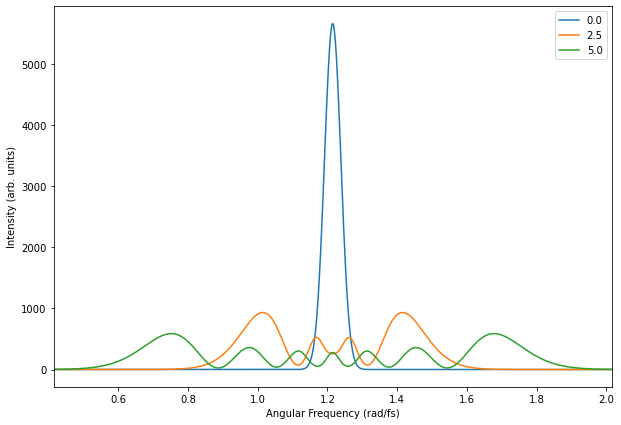

In [21]:
#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[0, :].squeeze())**2), label=str(0/1000*5.0))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[500, :].squeeze())**2), label=str(500/1000*5.0))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[-1, :].squeeze())**2), label=str(1000/1000*5.0))
plt.xlim(wc - 0.8, wc + 0.8)

plt.legend()
plt.xlabel('Angular Frequency (rad/fs)')
plt.ylabel('Intensity (arb. units)')

There is equal broadening on either side as the system is symmetric in frequency.  As noted, this can be used to shorten the input pulse through this spectral broadening.

### Postive Second-Order Dispersion

In [22]:
#Retrieve values after setting pulse above
wc, fwhm, t_ax, A, E = pulse_set.result

#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(E.size, dt)

z = np.linspace(0, 5.0, 1000)

beta2 = 1000
beta3 = 0

gamma = 4.0
A_out, A_out_f = split_step(A, z, w/2/np.pi, dt, beta2, beta3, gamma)




Text(0, 0.5, 'Intensity (arb. units)')

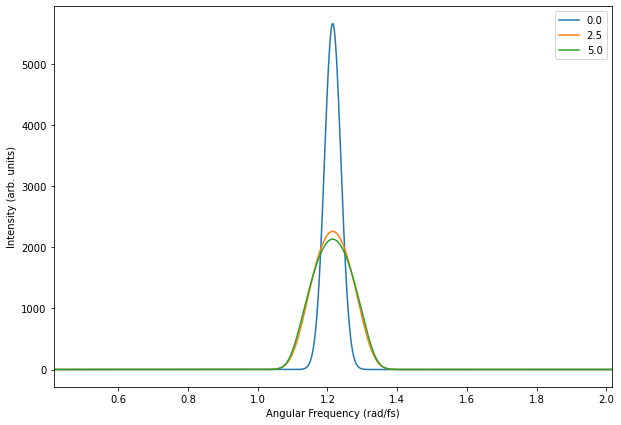

In [23]:
#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[0, :].squeeze())**2), label=str(0/1000*5.0))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[500, :].squeeze())**2), label=str(500/1000*5.0))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[-1, :].squeeze())**2), label=str(1000/1000*5.0))
plt.xlim(wc - 0.8, wc + 0.8)

plt.legend()
plt.xlabel('Angular Frequency (rad/fs)')
plt.ylabel('Intensity (arb. units)')

Second order dispersion quickly broadens the pulse in time preventing subsequent broadening.  Thus, to shorten a pulse, we need to operate around points with little second order dispersion.  

These points can be engineered via material choice and waveguide geometry.  Remember, we often perform this self-phase modulation within a waveguide, which carries its own dispersion that can be used to balance that of the chosen waveguide materials.  Thus, we want to design our nonlinear waveguides for pulse broadening to have regions of zero dispersion (i.e. $k'' = 0$) that lie within the pump bandwidth.  You will often see reference to "zero-dipsersion wavelength" within papers that discuss supercontinuum generation in fibers and waveguides.

Realistically, however, this does not mean that higher-order dispersion does not still exist.  Thus, we need to consider the case when $k'' = 0$ but $k''' \neq 0$. 

### Considering $k''' \neq 0$ when $k'' = 0$

Note the split-step solver above  takes the input `beta3` for the third-order dispersion, related to the third order derivative of $k$ with respect to $\omega$, $k'''$.  If $k''' > 0$ and $k'' = 0$ at the central frequency of the pump pulse, then the spectra generated above the central frequency sees normal dispersion and broaden continuously (dispersive-wave generation), while regions less than the central frequency see negative dispersion and are soliton-like and see less broadening.  In other words, after splitting, each half in frequency space behaves like the soliton and dispersive-wave generation examples we have already explored above.

To see why this is the case, remember that $k''(\omega) \approx \omega k'''$ according to the Taylor expansion.  

In [24]:
#Retrieve values after setting pulse above
wc, fwhm, t_ax, A, E = pulse_set.result

#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(E.size, dt)

z = np.linspace(0, 5.0, 1000)
# beta2 = 2000
# beta3 = -5000
beta2 = 0
beta3 = 100

gamma = 1.5
A_out, A_out_f = split_step(A, z, w/2/np.pi, dt, beta2, beta3, gamma)




Text(0, 0.5, 'Intensity (arb. units)')

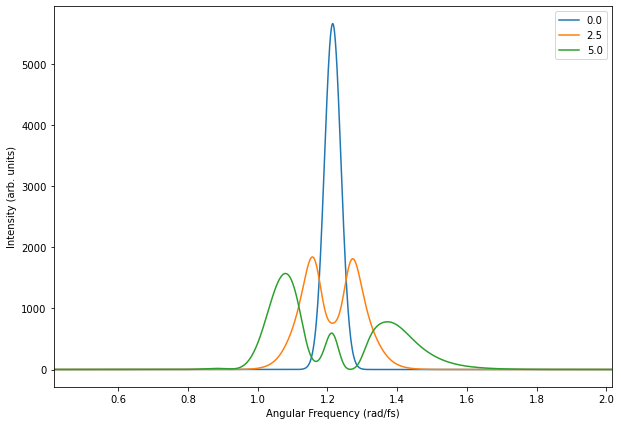

In [25]:
#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[0, :].squeeze())**2), label=str(0/1000*5.0))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[500, :].squeeze())**2), label=str(500/1000*5.0))
plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_out_f[-1, :].squeeze())**2), label=str(1000/1000*5.0))
plt.xlim(wc - 0.8, wc + 0.8)

plt.legend()
plt.xlabel('Angular Frequency (rad/fs)')
plt.ylabel('Intensity (arb. units)')

This is an important case to study as most realistic supercontinuum generation happens under similar conditions, especially within optical fibers (for instance photonic crystal fibers).  

When considering compression, we can take a look at the group delay $d\phi/d\omega$ of the output pulse:

Text(0, 0.5, 'Group Delay (fs)')

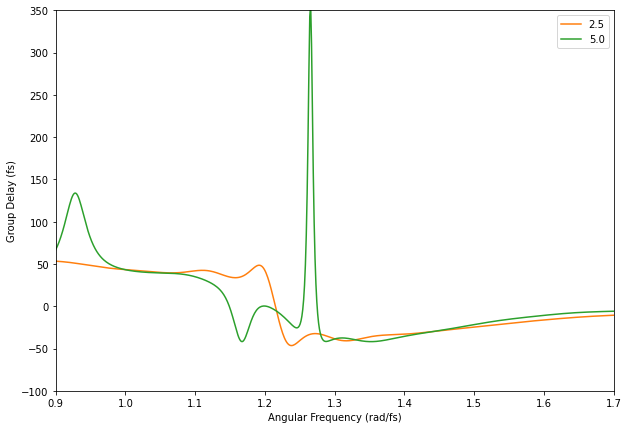

In [26]:
#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

dw = w[1] - w[0]
plt.plot(np.fft.fftshift(w + wc)[0:-1], np.diff(np.unwrap(np.angle(np.fft.fftshift(A_out_f[500, :].squeeze())**2)))/dw, label=str(500/1000*5), color='tab:orange')
plt.plot(np.fft.fftshift(w + wc)[0:-1], np.diff(np.unwrap(np.angle(np.fft.fftshift(A_out_f[-1, :].squeeze())**2)))/dw, label=str(1000/1000*5), color='tab:green')
plt.xlim(0.9, 1.7)
plt.ylim(-100, 350)

plt.legend()
plt.xlabel('Angular Frequency (rad/fs)')
plt.ylabel('Group Delay (fs)')

Note that the higher frequencies (dispersive wave) exhibit a fairly smooth phase and are fairly easy to compress.  See [Sell et al.](https://drive.google.com/file/d/1dqaGewRxMqnXj59H28aOy4OHbwQjsz0M/view?usp=sharing) for a very thorough study of similar supercontinuum generation in erbium-dobed fibers, which at the time was used to create some of the shortest pulses generated within a compact fiber-based system at megahertz repetition rates.  To achieve this result, the higher frequency components with smooth phase were isolated via filtering and compressed using a prism pair.  

**Question:** Why were the lower-frequencies not included?

For another reference into the impressive advances in waveguide-based light sources, I would also recommend [Carlson et. al.](https://drive.google.com/file/d/1olfUjXnzcvY54fsVEOZNgaGFGhZ4gI5-/view?usp=sharing) where they are able to use nonlinearities and electro-optics for the generation and compression of few-cycle pulses starting from a continuous-wave source.

**Suggested Exercise:** Numerically filter out the higher frequency components of the broadened pulse calculated above.  How short can you compress it by adding in compensating amounts of second-order dispersion?  


## $\chi^{(3)}$ in sub-wavelength structures: all optical switching

There are two exciting and emerging trends in photonics: (1) it is becoming easier to fabricate and design sub-wavelength photonic structures from various media exhibing high nonlinearity; (2) waveguide-based sources of ultrafast light are improving at a dramatic pace.  We already know that the increased peak intensities of ultrafast light increase the nonlinear interaction with media, and this can be increased even further through the use of sub-wavelength structuring for geometric and resonant field enhancement.

One application is all optical switching.  Since the nonlinear interaction from $\chi^{(3)}$ locally influences refractive index, light can be used to alter how a signal is routed through a system.  Let's revisit the [Fabry-Perot resonator](https://drive.google.com/file/d/1qFtRer1n6lHchWxNbD47yfZcs41NhIrJ/view?usp=sharing).  We already know that when the optical path length of the resonator is on the order of one wavelength ($L = \lambda_{\text{mat}} = 2\pi/(nk_0)$, where we assume the resonator is filled with material having refractive index $n$) transmission peaks.  However, when this optical length increases by just a quarter of a wavelength to $1.25\lambda_\text{mat}$ transmission is at a minimum resulting in high reflection.  Thus, one can imagine that if the cavity is filled with a material with large enough $\chi^{(3)}$ and driven by a short pulse with large-enough peak intensity, one could achieve an effect where the driving pulse could switch the behavior of the cavity in real time from "on" (high transmission) to "off" (low transmission).  This is because the intensity-dependent index contribution adds to the index, thus increasing $L/\lambda_\text{mat} = L(n + \Delta n)k_0/(2\pi)$.    

To examine this further, we can perform full electromagnetic simulation using [MEEP](https://meep.readthedocs.io/en/latest/) (a seriously amazing open-source electromagnetic solver that you should look into if interested) with the inclusion of $\chi^{(3)}$ nonlinearity.  We create a Fabry-Perot cavity by simply using a one-wavelength slab of high-index material ($\epsilon = 12$, similar to silicon). We can then examine the transmitted field from a pulse: (1) without any structure; (2) with the structure, but with $\chi^{(3)}$ turned off; and (3) with the structure but with $\chi^{(3)}$ such that the effective path length increases minimizing transmission.  

If interested, I have included the python MEEP code in the drive folder [here](https://drive.google.com/file/d/1SNQAst6_XwYoW_JIsy0ojCCy8Hn-RO3i/view?usp=sharing). 

First, we load the data from the simulation.  

**Note About Loading The h5 Data Files:**  The data files from the electromagnetic simulation are stored in the shared drive space.  They are in h5 format.  If running this notebook on your computer, you must download them and put them in the local directory of the notebook.  If on Google Colaboratory, you must load them into the notebook space:

 1. Download the h5 files from the [Recitation 4 drive folder](https://drive.google.com/drive/folders/1ZRpfZWBphLhFikFmgQDwWK1fccPsAe89?usp=sharing)
 2. Click the file icon in the left pane of Google Colaboratory
 2. Upload the h5 files.  These will be deleted at the end of the session so you must do it each time you load this notebook.

**Note About MEEP Simulations** I provide the MEEP simulation python script [here in the drive](https://drive.google.com/file/d/1SNQAst6_XwYoW_JIsy0ojCCy8Hn-RO3i/view?usp=sharing) for those interested.  Consult the [documentation for MEEP](https://meep.readthedocs.io/en/latest/) for installation instructions.  If there is interest, I could demonstrate this in a recitation video.  Send me a message to let me know.

In [27]:
file_name = 'data/supercontinuum-Ey-slab-w-chi3-75.0-lambda-0.0-HR.h5'
data = h5py.File(file_name, 'r+')
ey_no_cavity = np.array(data['ey']).squeeze()
data.close()

file_name = 'data/supercontinuum-Ey-slab-w-chi3-00.0-lambda-1.0-HR.h5'
data = h5py.File(file_name, 'r+')
ey_cavity = np.array(data['ey']).squeeze()
data.close()

file_name = 'data/supercontinuum-Ey-slab-w-chi3-75.0-lambda-1.0-HR.h5'
data = h5py.File(file_name, 'r+')
ey_cavity_chi3 = np.array(data['ey']).squeeze()
data.close()

The simulation is a 2D simulation in $x$ and $y$.  It has a plane-wave source at the left-most boundary that propagates from left to right and polarized in $y$.  In the middle is a vertical slab of the material with $\epsilon = 12$ whos thickness was chosen to be such that $\lambda_\text{mat} = 1.55$ $\mu$m, the wavelength of the plane wave source.  

Below we plot the output fields across the entire simulation region at one point in time for visualization.  We compare the two cases of (2) the structure without $\chi^{(3)}$, and (3) the structure with $\chi^{(3)}$.  You can see the wavelength tightening near the slab region in the center, the development of higher frequencies within the slab when $\chi^{(3)}$ is turned on.  The color axis has been saturated for clarity (why you see the "glowing" source on the left). The dashed lines show the outline of the material slab at the center of the simulation cell. 

Text(0, 0.5, 'y ($\\mu$m)')

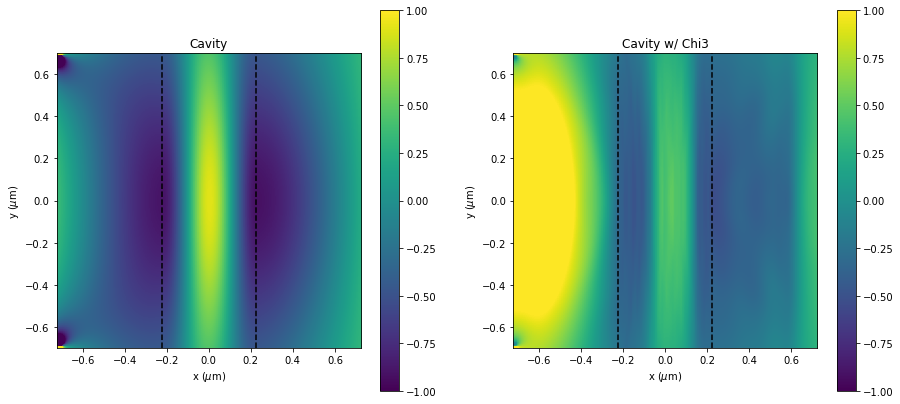

In [28]:
fig = plt.figure()
fig.set_size_inches(15, 7)

fcen = 1/1.55
eps = 12
slab_width = (1/fcen)/np.sqrt(eps)

#Size of the cell in x and y
sx=slab_width + 1.0
sy=1.4

#Extent of region to plot in microns
extent = [-sx/2, sx/2, -sy/2, sy/2]

ax_cavity = fig.add_subplot(1, 2, 1)
cavity = ax_cavity.imshow(ey_cavity[:, :, 199].squeeze().transpose(), 
                          extent=extent)
ax_cavity.set_title('Cavity')
fig.colorbar(cavity, ax=ax_cavity)
cavity.set_clim(-1.0, 1.0)
ax_cavity.axvline(x=-slab_width/2.0, 
                  linestyle='--',
                  color='black')
ax_cavity.axvline(x=slab_width/2.0, 
                  linestyle='--',
                  color='black')
ax_cavity.set_xlabel('x ($\mu$m)')
ax_cavity.set_ylabel('y ($\mu$m)')

ax_cavity_chi3 = fig.add_subplot(1, 2, 2)
cavity_chi3 = ax_cavity_chi3.imshow(ey_cavity_chi3[:, :, 201].squeeze().transpose(),
                                    extent=extent)
ax_cavity_chi3.set_title('Cavity w/ Chi3')
fig.colorbar(cavity_chi3, ax=ax_cavity_chi3)
cavity_chi3.set_clim(-1.0, 1.0)
ax_cavity_chi3.axvline(x=-slab_width/2.0, 
                  linestyle='--',
                  color='black')
ax_cavity_chi3.axvline(x=slab_width/2.0, 
                  linestyle='--',
                  color='black')
ax_cavity_chi3.set_xlabel('x ($\mu$m)')
ax_cavity_chi3.set_ylabel('y ($\mu$m)')




Next, we extract only the fields near the end of the cell on the right at the center -- these will be the "output" fields that transmit through the structure.

In [29]:
time_sample_rate = 10.0
fcen = 1/1.55
df = 0.2
dt = (1.0*1e-6*1e15/c)/(fcen + 0.5*df)/time_sample_rate

t_no_cavity = np.arange(0, ey_no_cavity.shape[2])*dt
t_cavity = np.arange(0, ey_cavity.shape[2])*dt
t_cavity_chi3 = np.arange(0, ey_cavity_chi3.shape[2])*dt

ey_no_cavity_out = np.mean(ey_no_cavity[-1, range(65, 75), :].squeeze(), axis=0)
ey_cavity_out = np.mean(ey_cavity[-1, range(65, 75), :].squeeze(), axis=0)
ey_cavity_chi3_out = np.mean(ey_cavity_chi3[-1, range(65, 75), :].squeeze(), axis=0)

Now we verify our design by first showing that the transmitted energy for case (1) and (2) are roughly equal -- that is we have peak transmission wihtout any $\chi^{(3)}$.  

Text(0, 0.5, 'Intensity (arb. units)')

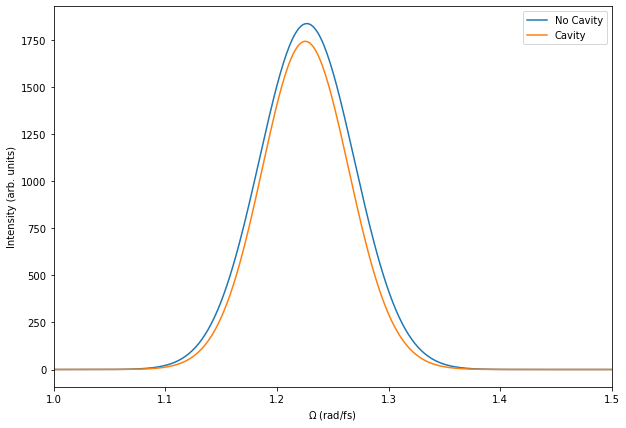

In [30]:
#Take the FT of the envelope
N_samples = 10000
ey_no_cavity_out_f = np.fft.fft(ey_no_cavity_out, N_samples)
ey_cavity_out_f = np.fft.fft(ey_cavity_out, N_samples)

w_out = 2*np.pi*np.fft.fftfreq(N_samples, dt)

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w_out), np.fft.fftshift(np.abs(ey_no_cavity_out_f))**2, label='No Cavity')
plt.plot(np.fft.fftshift(w_out), np.fft.fftshift(np.abs(ey_cavity_out_f))**2, label='Cavity')
plt.legend()
plt.xlim(1.0, 1.5)
plt.xlabel('$\Omega$ (rad/fs)')
plt.ylabel('Intensity (arb. units)')

As you can see, there is only a slight drop in transmission.  There could be other numerical reasons (such as the inclusion of the PML barriers and their interaction with the slab after it is introduced) that could result in the slight increase in absorption here.  Nonetheless, we can say it is negligible.  

This sets our baseline and lets us know that we have almost full transmission with this cavity length without $\chi^{(3)}$ included.  

Now we can compare the case of the cavity and the cavity wth $\chi^{(3)}$.  

Text(0, 0.5, 'Intensity (arb. units)')

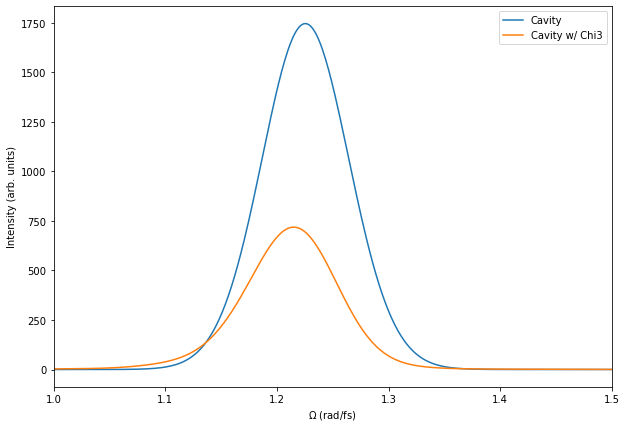

In [31]:
#Take the FT of the envelope
ey_cavity_chi3_out_f = np.fft.fft(ey_cavity_chi3_out, N_samples)

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w_out), np.fft.fftshift(np.abs(ey_cavity_out_f))**2, label='Cavity')
plt.plot(np.fft.fftshift(w_out), np.fft.fftshift(np.abs(ey_cavity_chi3_out_f))**2, label='Cavity w/ Chi3')
plt.legend()
plt.xlim(1.0, 1.5)
plt.xlabel('$\Omega$ (rad/fs)')
plt.ylabel('Intensity (arb. units)')

Note the significant drop in intensity.  The nonlinear interaction increased the effective path length quenching transmission.  There is no loss in the system, so this radiation is now reflected.  

We can also see a bit of third-harmonic generation if we extend our frequency axis and plot on a log-scale.

Text(0, 0.5, 'Intensity (arb. units)')

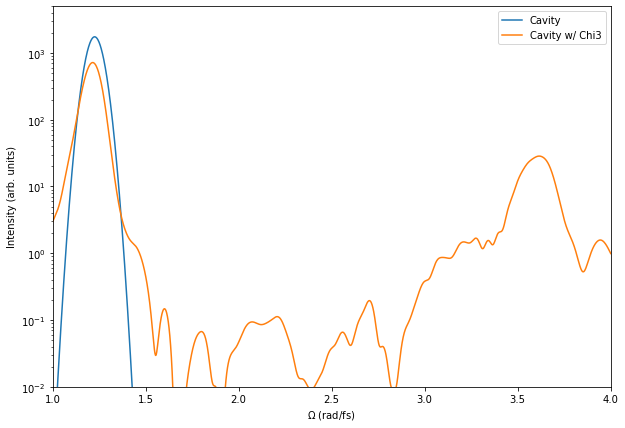

In [32]:
#Take the FT of the envelope
ey_cavity_chi3_out_f = np.fft.fft(ey_cavity_chi3_out, N_samples)

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.semilogy(np.fft.fftshift(w_out), np.fft.fftshift(np.abs(ey_cavity_out_f))**2, label='Cavity')
plt.semilogy(np.fft.fftshift(w_out), np.fft.fftshift(np.abs(ey_cavity_chi3_out_f))**2, label='Cavity w/ Chi3')
plt.legend()
plt.xlim(1.0, 4.0)
plt.ylim(1e-2, 5e3)
plt.xlabel('$\Omega$ (rad/fs)')
plt.ylabel('Intensity (arb. units)')

It's also instructive to look in the time-domain at the radiated output fields.

Text(0, 0.5, 'Output Field (arb. units)')

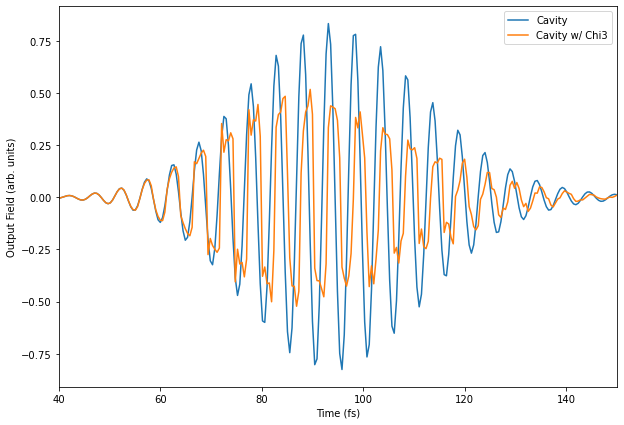

In [33]:
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(t_cavity, ey_cavity_out, label='Cavity')
plt.plot(t_cavity_chi3, ey_cavity_chi3_out, label='Cavity w/ Chi3')
plt.legend()
plt.xlim(40, 150)

plt.xlabel('Time (fs)')
plt.ylabel('Output Field (arb. units)')


Note on the leading edge, we can see that the radiation matches perfectly.  Then as intensity increases, you see the increase in the higher-frequency ripples.  These add to the main pulse, and accompany a phase shift of the fundamental for the case with $\chi^{(3)}$.  As expected, this phase-shift is roughly $\pi/4$ reducing the transmission.  Of course, the leading radiation is not subject to this, only the trailing radiation, so the on-off ratio is not as good as would be predicted by a pure Fabry-Perot cavity.

## Further Reading

There is increasing literature on engineering such effects for optical switching and other applications, especially in combination with inverse-design techniques.  See for instance  [Hughes *et al.*](https://drive.google.com/file/d/1seKbOsX4frPhD159ZwLY2PcBefstWhBT/view?usp=sharing) where inverse design techniques are used to create sub-wavelength-structured switches that can route a pulsed signal in different directions depending on teh energy in the pulse.  While the structures are indeed more complex, this is conceptually quite similar to what we have discussed here.  